In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import bayesnet as bn

np.random.seed(1234)

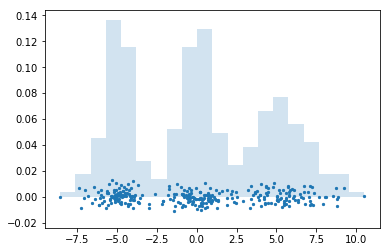

In [2]:
x_train = np.array([
    np.random.normal(loc=-5, scale=1, size=100),
    np.random.normal(loc=0., scale=1, size=100),
    np.random.normal(loc=5, scale=2, size=100)
]).flatten()

plt.scatter(x_train, np.random.normal(scale=0.005, size=x_train.size), s=5)
plt.hist(x_train, bins=20, normed=True, alpha=0.2)
plt.show()

In [3]:
class GaussianMixture(bn.Network):
    
    def __init__(self, n_component):
        super().__init__(
            c=np.ones(n_component),
            mu=np.random.randn(3),
            s=np.ones(n_component)
        )

    def __call__(self, x):
        self.x = bn.random.GaussianMixture(bn.softmax(self.c), self.mu, bn.softplus(self.s), data=x)
        return self.x.pdf().value

In [4]:
model = GaussianMixture(3)
optimizer = bn.optimizer.Adam(model, 1e-3)

for _ in range(10000):
    model.cleargrad()
    model(x_train[:, None])
    log_likelihood = model.log_pdf()
    log_likelihood.backward()
    optimizer.update()

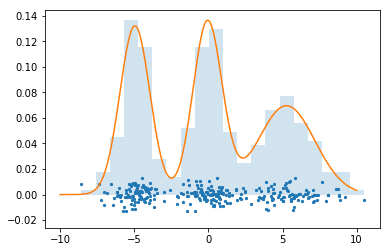

In [5]:
plt.scatter(x_train, np.random.normal(scale=0.005, size=x_train.size), s=5)
plt.hist(x_train, bins=20, normed=True, alpha=0.2)

x = np.linspace(-10, 10, 1000)
p = model(x[:, None])
plt.plot(x, p)
plt.show()

In [6]:
class GaussianMixtureEM(bn.Network):
    
    def __init__(self, n_component):
        super().__init__(
            c=np.ones(n_component),
            mu=np.random.randn(n_component),
            s=np.ones(n_component)
        )
        
    def __call__(self, x, z=None):
        if z is None:
            return bn.random.GaussianMixture(bn.softmax(self.c), self.mu, bn.softplus(self.s), data=x).pdf().value
        self.z = bn.random.Categorical(logit=bn.softmax(self.c), data=z)
        self.x = bn.random.GaussianMixture(z, self.mu, bn.softplus(self.s), data=x)
        return self.x.pdf().value * self.z.pdf().value

In [7]:
model = GaussianMixtureEM(3)
optimizer = bn.optimizer.Adam(model, 1e-3)

for _ in range(10):
    resp = np.stack([model(x_train[:, None], np.eye(3)[i]) for i in range(3)], axis=-1)
    resp /= resp.sum(axis=-1, keepdims=True)
    for _ in range(1000):
        model.cleargrad()
        model(x_train[:, None], resp)
        log_likelihood = model.log_pdf()
        log_likelihood.backward()
        optimizer.update()

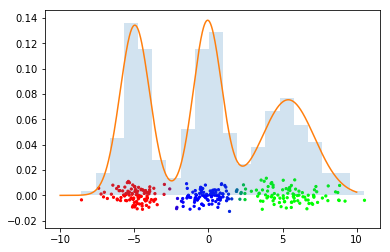

In [8]:
resp = np.stack([model(x_train[:, None], np.eye(3)[i]) for i in range(3)], axis=-1)
resp /= resp.sum(axis=-1, keepdims=True)
plt.scatter(x_train, np.random.normal(scale=0.005, size=x_train.size), s=5, c=resp)
plt.hist(x_train, bins=20, normed=True, alpha=0.2)

x = np.linspace(-10, 10, 1000)
p = model(x[:, None])
plt.plot(x, p)
plt.show()

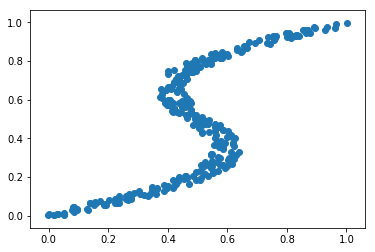

In [9]:
def func(x):
    return x + 0.3 * np.sin(2 * np.pi * x)

def sample(x, y, n=None):
    assert len(x) == len(y)
    N = len(x)
    if n is None:
        n = N
    indices = np.random.choice(N, n, replace=False)
    return x[indices], y[indices]

y_train = np.random.uniform(size=(300, 1))
x_train = func(y_train) + np.random.uniform(-0.05, 0.05, size=y_train.shape)

plt.scatter(x_train, y_train)

In [10]:
class MixtureDensityNetwork(bn.Network):
    
    def __init__(self, n_input, n_hidden, n_component=3):
        super().__init__(
            w1=np.random.normal(scale=0.1, size=(n_input, n_hidden)),
            b1=np.zeros(n_hidden),
            w2_coef=np.random.normal(scale=0.1, size=(n_hidden, n_component)),
            b2_coef=np.zeros(n_component),
            w2_mu=np.random.normal(scale=0.1, size=(n_hidden, n_component)),
            b2_mu=np.zeros(n_component),
            w2_s=np.random.normal(scale=0.1, size=(n_hidden, n_component)),
            b2_s=np.zeros(n_component)
        )

    def __call__(self, x, y=None):
        h = bn.tanh(x @ self.w1 + self.b1)
        coef = bn.softmax(h @ self.w2_coef + self.b2_coef)
        mu = h @ self.w2_mu + self.b2_mu
        std = bn.softplus(h @ self.w2_s + self.b2_s)
        self.y = bn.random.GaussianMixture(coef, mu, std, data=y)
        return self.y.pdf().value

In [11]:
model = MixtureDensityNetwork(1, 5)
optimizer = bn.optimizer.Adam(model, 1e-4)

for _ in range(50000):
    model.cleargrad()
    batch = sample(x_train, y_train, n=100)
    model(*batch)
    log_likelihood = model.log_pdf()
    log_likelihood.backward()
    optimizer.update()

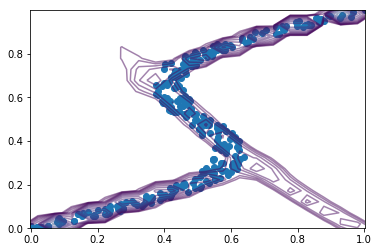

In [12]:
xy_grid = np.mgrid[-2:3:100j, -2:3:100j]
x, y = xy_grid[0], xy_grid[1]

plt.scatter(x_train, y_train)
prob = model(x.reshape(-1, 1), y.reshape(-1, 1)).reshape(100, 100)
levels_log = np.linspace(0, np.log(prob.max()), 21)
levels = np.exp(levels_log)
levels[0] = 0
plt.contour(x, y, prob, levels, alpha=0.5)
plt.xlim(x_train.min(), x_train.max())
plt.ylim(y_train.min(), y_train.max())
plt.show()